In [1]:
# ==============================
# 데이터 로딩 (addition.txt)
# ==============================
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ==============================
# 시드 고정
# ==============================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# ------------------------------
# Dataset 정의 (고정 길이, '_' 시작)
# ------------------------------
class AddDataset(Dataset):
    def __init__(self, samples, stoi=None, itos=None):
        self.samples = samples

        if stoi is None:
            # 전체 문자 + '_' 포함
            vocab = set("".join(s for s, _ in samples) +
                        "".join(t for _, t in samples) + "_")
            self.stoi = {s: i for i, s in enumerate(sorted(vocab))}
        else:
            self.stoi = stoi

        self.itos = {i: s for s, i in self.stoi.items()}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        src, tgt = self.samples[idx]

        # 입력: 그대로 (길이 7 보장, 뒤 공백 포함)
        src_ids = [self.stoi[c] for c in src]

        # 출력: '_' + tgt (길이 5 보장, tgt도 뒤 공백 포함)
        tgt_ids = [self.stoi["_"]] + [self.stoi[c] for c in tgt]

        return torch.tensor(src_ids), torch.tensor(tgt_ids), src, tgt


# ------------------------------
# collate_fn: pad 불필요, 그냥 stack
# ------------------------------
def collate_fn(batch):
    src_batch, tgt_batch, src_strs, tgt_strs = zip(*batch)
    return torch.stack(src_batch), torch.stack(tgt_batch), src_strs, tgt_strs


# ==============================
# 데이터셋 불러오기
# ==============================
all_samples = []
with open("addition.txt", encoding="utf-8") as f:
    for line in f:
        line = line[:-1] if line.endswith("\n") else line  # 개행만 제거
        if not line:
            continue
        src, tgt = line.split("_")  # '_' 기준 분리

        # 항상 src=7, tgt=4 고정
        assert len(src) == 7, f"src 길이 오류: {repr(src)}"
        assert len(tgt) == 4, f"tgt 길이 오류: {repr(tgt)}"

        all_samples.append((src, tgt))

# train/val 분리
train_samples, test_samples = train_test_split(all_samples, test_size=0.1, random_state=42)

# Dataset 생성
train_dataset = AddDataset(train_samples)
test_dataset = AddDataset(test_samples, stoi=train_dataset.stoi, itos=train_dataset.itos)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)


# ==============================
# 데이터 예시 출력
# ==============================
for src_batch, tgt_batch, src_strs, tgt_strs in train_loader:
    print("입력 배치 shape:", src_batch.shape)  # [B, 7]
    print("출력 배치 shape:", tgt_batch.shape)  # [B, 5]

    for i in range(len(src_strs)):
        print(f"\n[샘플 {i}]")
        print(f"  원문: {repr(src_strs[i])} → {repr(tgt_strs[i])}")

        # 토큰 변환 확인
        src_tokens = [train_dataset.itos[idx.item()] for idx in src_batch[i]]
        tgt_tokens = [train_dataset.itos[idx.item()] for idx in tgt_batch[i]]

        print("  입력 인덱스:", src_batch[i].tolist())
        print("  입력 토큰 :", src_tokens)
        print("  출력 인덱스:", tgt_batch[i].tolist())
        print("  출력 토큰 :", tgt_tokens)
        break

    break  # 첫 배치만 확인


Device: cuda:6
입력 배치 shape: torch.Size([128, 7])
출력 배치 shape: torch.Size([128, 5])

[샘플 0]
  원문: '72+147 ' → '219 '
  입력 인덱스: [9, 4, 1, 3, 6, 9, 0]
  입력 토큰 : ['7', '2', '+', '1', '4', '7', ' ']
  출력 인덱스: [12, 4, 3, 11, 0]
  출력 토큰 : ['_', '2', '1', '9', ' ']


In [2]:
# ==============================
# 9.3.2 모델 정의 (Addition: Attention 없는 Seq2Seq, )
# ==============================

import torch
import torch.nn as nn

# ==============================
# Encoder 정의
# ==============================
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

    def forward(self, src):
        """
        src: [batch_size, src_len=7]
        """
        embedded = self.embedding(src)                   # [B, 7, E]
        _, (hidden, cell) = self.lstm(embedded)
        return hidden, cell


# ==============================
# Decoder 정의
# ==============================
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, hidden, cell):
        """
        input: [B]  (단일 토큰 인덱스, '_' 또는 숫자/공백)
        hidden, cell: [num_layers, B, H]
        """
        input = input.unsqueeze(1)                       # [B, 1]
        embedded = self.embedding(input)                 # [B, 1, E]
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))      # [B, vocab]
        return prediction, hidden, cell


# ==============================
# Seq2Seq (Encoder–Decoder 통합)
# ==============================
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=1.0):
        """
        src: [B, 7]
        trg: [B, 5]   (항상 '_' + 4자리)
        """
        B = src.size(0)
        Tt = trg.size(1)  # 5
        V = self.decoder.fc_out.out_features

        outputs = torch.zeros(B, Tt, V, device=self.device)

        hidden, cell = self.encoder(src)

        # 첫 입력은 항상 '_' (trg[:,0])
        input = trg[:, 0]

        # t=1~4 자리 예측
        for t in range(1, Tt):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)

            input = trg[:, t] if teacher_force else top1

        return outputs


In [3]:
import torch

@torch.no_grad()
def greedy_decode_seq2seq(model, src, stoi, itos, device, max_len=4):
    """
    src: [1, src_len=7]
    출력: 항상 길이 4 문자열 (뒤 공백 포함)
    """
    model.eval()
    hidden, cell = model.encoder(src)  # 인코더 실행

    # 첫 입력은 '_' 토큰
    input_token = torch.tensor([stoi["_"]], device=device)

    outputs = []
    for _ in range(4):  # 항상 4 step
        output, hidden, cell = model.decoder(input_token, hidden, cell)  # [1, V]
        top1 = output.argmax(1)  # [1]
        outputs.append(top1.item())
        input_token = top1

    return outputs  # 토큰 인덱스 리스트


def tokenize_fixed(x: str):
    """
    문자열을 그대로 문자 리스트로 변환 (공백 포함).
    ex) "16+75  " -> ["1","6","+","7","5"," "," "]
    """
    return list(x)


@torch.no_grad()
def evaluate_seq2seq(model, x, stoi, itos, device, max_len=4):
    """
    x: 문자열 입력 (예: "123+456")
    max_len: 출력 고정 길이 (기본 4)
    """
    # 문자열 → 인덱스
    x_idx = [stoi[c] for c in x]
    src = torch.tensor(x_idx, device=device).unsqueeze(0)

    # 디코딩
    pred_idx = greedy_decode_seq2seq(model, src, stoi, itos, device, max_len)
    pred = "".join([itos[i] for i in pred_idx])
    return pred


In [4]:
# ==============================
# 하이퍼파라미터 & 모델 초기화
# ==============================
import torch
import torch.nn as nn
import torch.optim as optim

# ------------------------------
# 하이퍼파라미터
# ------------------------------
INPUT_DIM = len(train_dataset.stoi)   # 입력 vocab 크기
OUTPUT_DIM = len(train_dataset.stoi)  # 출력 vocab 크기 (공용 vocab)
EMB_DIM = 32
HIDDEN_DIM = 192
N_EPOCHS = 50
PATIENCE = 15
MIN_DELTA = 1e-3
CLIP = 5.0
LR = 0.001

# ------------------------------
# 모델 정의
# ------------------------------
enc = Encoder(INPUT_DIM, EMB_DIM, HIDDEN_DIM).to(device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HIDDEN_DIM).to(device)
model = Seq2Seq(enc, dec, device).to(device)

# ------------------------------
# 손실 함수 & 옵티마이저 (ignore_index 제거)
# ------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


In [5]:
# ==============================
# 평가 지표
# ==============================
def token_accuracy_fn(y_pred, y_true):
    """
    토큰 단위 정확도 (pad 없음)
    y_pred: [B, T, V] (logits)
    y_true: [B, T] (ids)
    """
    pred_tokens = y_pred.argmax(dim=2)  # [B, T]
    correct = (pred_tokens == y_true)
    acc = correct.sum().float() / torch.numel(y_true)
    return acc.item()


# ------------------------------
# 문자열 정리 함수
# ------------------------------
def clean_str(s: str):
    """
    <sos>, <eos>, <pad> 없음.
    그대로 비교하되, 사람 보기용으로는 rstrip() 정도만.
    """
    return s.rstrip()


@torch.no_grad()
def exact_match_fn(model, dataset, stoi, itos, device, n_samples=None):
    """
    Exact Match 평가 (출력 전체 문자열이 정답과 동일한지 확인)
    """
    if n_samples is None or n_samples >= len(dataset):
        indices = range(len(dataset))
    else:
        indices = random.sample(range(len(dataset)), n_samples)

    correct = 0
    for idx in indices:
        _, _, src_str, tgt_str = dataset[idx]

        # pred_str: 항상 길이 4 문자열 (뒤 공백 포함)
        pred_str = evaluate_seq2seq(
            model, src_str,
            stoi=stoi, itos=itos,
            device=device
        )

        if pred_str == tgt_str:   # 공백 포함 그대로 비교
            correct += 1

    return correct / len(indices)


In [6]:
# ----------------------------------------------------------
# 1 epoch 학습 
# ----------------------------------------------------------
def train_one_epoch(model, loader, optimizer, criterion, epoch, clip=5.0, tf_ratio=1.0):
    model.train()
    total_loss = 0.0
    total_acc = 0.0

    for src, trg, _, _ in tqdm(loader, desc=f"Train Epoch {epoch}", leave=False):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()

        # forward
        output = model(src, trg, teacher_forcing_ratio=tf_ratio)  # [B, T, V]

        V = output.shape[-1]
        # 그대로 loss 계산 (trg는 '_' + 4자리 → 길이 5)
        output_flat = output.reshape(-1, V)   # [B*T, V]
        trg_flat = trg.reshape(-1)            # [B*T]

        loss = criterion(output_flat, trg_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        # 토큰 정확도
        B, T = trg.size()
        output_eval = output.view(B, T, V)
        acc = token_accuracy_fn(output_eval, trg)

        total_loss += loss.item()
        total_acc += acc

    n = len(loader)
    return total_loss / n, total_acc / n


# ----------------------------------------------------------
# 1 epoch 평가 
# ----------------------------------------------------------
@torch.no_grad()
def evaluate_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    for src, trg, _, _ in loader:
        src, trg = src.to(device), trg.to(device)

        output = model(src, trg, teacher_forcing_ratio=0.0)  # [B, T, V]

        V = output.shape[-1]
        output_flat = output.reshape(-1, V)
        trg_flat = trg.reshape(-1)

        loss = criterion(output_flat, trg_flat)

        # 토큰 정확도
        B, T = trg.size()
        output_eval = output.view(B, T, V)
        acc = token_accuracy_fn(output_eval, trg)

        total_loss += loss.item()
        total_acc += acc

    n = len(loader)
    return total_loss / n, total_acc / n


In [7]:
# ==============================
# 학습 루프 (Exact Match 기반 Early Stopping)
# ==============================
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_exact_accs = []   # train_exact_accs는 생략

best_val_eacc = 0.0
patience_counter = 0

for epoch in range(1, N_EPOCHS + 1):
    # ------------------------------
    # 1) 학습 / 평가
    # ------------------------------
    tr_loss, tr_acc = train_one_epoch(
        model, train_loader, optimizer, criterion,
        epoch, clip=CLIP
    )
    va_loss, va_acc = evaluate_one_epoch(
        model, test_loader, criterion
    )

    # Validation은 전체 데이터셋으로 Exact Match 평가
    va_eacc = exact_match_fn(
        model, test_dataset,
        stoi=train_dataset.stoi,
        itos=train_dataset.itos,
        device=device,
        n_samples=None   # None → 전체 데이터 평가
    )

    # ------------------------------
    # 2) 기록
    # ------------------------------
    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc); val_accs.append(va_acc)
    val_exact_accs.append(va_eacc)

    print(f"Epoch {epoch:03d} | "
          f"Train Loss: {tr_loss:.5f} | Token Acc: {tr_acc:.5f} || "
          f"Val Loss: {va_loss:.5f} | Token Acc: {va_acc:.5f} | Exact Acc: {va_eacc:.5f} "
          f"(Best Val Exact: {best_val_eacc:.5f}, Patience: {patience_counter})")

    # ------------------------------
    # 3) 샘플 디버그 출력
    # ------------------------------
    if epoch % 1 == 0:
        src_ids, tgt_ids, src_str, tgt_str = random.choice(test_dataset)
        pred = evaluate_seq2seq(
            model, src_str,
            stoi=train_dataset.stoi,
            itos=train_dataset.itos,
            device=device,
            max_len=len(tgt_str)   # 고정 길이
        )
        print(f"[DEBUG] 입력: {src_str} | 정답: {clean_str(tgt_str)} | 예측: {clean_str(pred)}")

    # ------------------------------
    # 4) Early Stopping (Exact Match 기준)
    # ------------------------------
    if va_eacc > best_val_eacc + MIN_DELTA:
        best_val_eacc = va_eacc
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered!")
            break


Epoch 001 | Train Loss: 1.83550 | Token Acc: 0.31108 || Val Loss: 1.72297 | Token Acc: 0.36863 | Exact Acc: 0.00960 (Best Val Exact: 0.00000, Patience: 0)
[DEBUG] 입력: 541+286 | 정답: 827 | 예측: 683


Epoch 002 | Train Loss: 1.52113 | Token Acc: 0.41981 || Val Loss: 1.51342 | Token Acc: 0.43188 | Exact Acc: 0.02360 (Best Val Exact: 0.00960, Patience: 0)
[DEBUG] 입력: 639+49  | 정답: 688 | 예측: 704


Epoch 003 | Train Loss: 1.37461 | Token Acc: 0.47236 || Val Loss: 1.39280 | Token Acc: 0.47930 | Exact Acc: 0.04740 (Best Val Exact: 0.02360, Patience: 0)
[DEBUG] 입력: 905+302 | 정답: 1207 | 예측: 1199


Epoch 004 | Train Loss: 1.27928 | Token Acc: 0.50763 || Val Loss: 1.34943 | Token Acc: 0.50301 | Exact Acc: 0.05740 (Best Val Exact: 0.04740, Patience: 0)
[DEBUG] 입력: 278+29  | 정답: 307 | 예측: 313


Epoch 005 | Train Loss: 1.21428 | Token Acc: 0.53229 || Val Loss: 1.31144 | Token Acc: 0.52574 | Exact Acc: 0.07900 (Best Val Exact: 0.05740, Patience: 0)
[DEBUG] 입력: 5+337   | 정답: 342 | 예측: 345


Epoch 006 | Train Loss: 1.16334 | Token Acc: 0.55110 || Val Loss: 1.28232 | Token Acc: 0.53777 | Exact Acc: 0.09980 (Best Val Exact: 0.07900, Patience: 0)
[DEBUG] 입력: 0+94    | 정답: 94 | 예측: 95


Epoch 007 | Train Loss: 1.12396 | Token Acc: 0.56430 || Val Loss: 1.29245 | Token Acc: 0.54547 | Exact Acc: 0.11200 (Best Val Exact: 0.09980, Patience: 0)
[DEBUG] 입력: 883+18  | 정답: 901 | 예측: 901


Epoch 008 | Train Loss: 1.08859 | Token Acc: 0.57694 || Val Loss: 1.25842 | Token Acc: 0.56266 | Exact Acc: 0.13080 (Best Val Exact: 0.11200, Patience: 0)
[DEBUG] 입력: 89+586  | 정답: 675 | 예측: 678


Epoch 009 | Train Loss: 1.05939 | Token Acc: 0.58642 || Val Loss: 1.26366 | Token Acc: 0.56641 | Exact Acc: 0.14300 (Best Val Exact: 0.13080, Patience: 0)
[DEBUG] 입력: 78+572  | 정답: 650 | 예측: 651


Epoch 010 | Train Loss: 1.03968 | Token Acc: 0.59193 || Val Loss: 1.26059 | Token Acc: 0.57434 | Exact Acc: 0.17080 (Best Val Exact: 0.14300, Patience: 0)
[DEBUG] 입력: 752+405 | 정답: 1157 | 예측: 1162


Epoch 011 | Train Loss: 1.02071 | Token Acc: 0.59799 || Val Loss: 1.26274 | Token Acc: 0.57465 | Exact Acc: 0.16120 (Best Val Exact: 0.17080, Patience: 0)
[DEBUG] 입력: 389+49  | 정답: 438 | 예측: 439


Epoch 012 | Train Loss: 1.00370 | Token Acc: 0.60439 || Val Loss: 1.24892 | Token Acc: 0.58363 | Exact Acc: 0.18300 (Best Val Exact: 0.17080, Patience: 1)
[DEBUG] 입력: 648+60  | 정답: 708 | 예측: 710


Epoch 013 | Train Loss: 0.98856 | Token Acc: 0.60891 || Val Loss: 1.26416 | Token Acc: 0.58492 | Exact Acc: 0.18160 (Best Val Exact: 0.18300, Patience: 0)
[DEBUG] 입력: 10+19   | 정답: 29 | 예측: 30


Epoch 014 | Train Loss: 0.98141 | Token Acc: 0.61168 || Val Loss: 1.22846 | Token Acc: 0.59512 | Exact Acc: 0.21300 (Best Val Exact: 0.18300, Patience: 1)
[DEBUG] 입력: 625+965 | 정답: 1590 | 예측: 1573


Epoch 015 | Train Loss: 0.95908 | Token Acc: 0.62048 || Val Loss: 1.26040 | Token Acc: 0.59344 | Exact Acc: 0.21360 (Best Val Exact: 0.21300, Patience: 0)
[DEBUG] 입력: 0+288   | 정답: 288 | 예측: 288


Epoch 016 | Train Loss: 0.95107 | Token Acc: 0.62260 || Val Loss: 1.24471 | Token Acc: 0.60242 | Exact Acc: 0.23500 (Best Val Exact: 0.21300, Patience: 1)
[DEBUG] 입력: 401+352 | 정답: 753 | 예측: 750


Epoch 017 | Train Loss: 0.93824 | Token Acc: 0.62809 || Val Loss: 1.27065 | Token Acc: 0.59965 | Exact Acc: 0.21980 (Best Val Exact: 0.23500, Patience: 0)
[DEBUG] 입력: 483+77  | 정답: 560 | 예측: 559


Epoch 018 | Train Loss: 0.93064 | Token Acc: 0.62958 || Val Loss: 1.27430 | Token Acc: 0.60484 | Exact Acc: 0.23520 (Best Val Exact: 0.23500, Patience: 1)
[DEBUG] 입력: 343+94  | 정답: 437 | 예측: 439


Epoch 019 | Train Loss: 0.92208 | Token Acc: 0.63342 || Val Loss: 1.29496 | Token Acc: 0.60313 | Exact Acc: 0.23640 (Best Val Exact: 0.23500, Patience: 2)
[DEBUG] 입력: 861+414 | 정답: 1275 | 예측: 1262


Epoch 020 | Train Loss: 0.91494 | Token Acc: 0.63569 || Val Loss: 1.26746 | Token Acc: 0.60801 | Exact Acc: 0.23700 (Best Val Exact: 0.23640, Patience: 0)
[DEBUG] 입력: 51+193  | 정답: 244 | 예측: 245


Epoch 021 | Train Loss: 0.90453 | Token Acc: 0.64003 || Val Loss: 1.26199 | Token Acc: 0.61473 | Exact Acc: 0.25780 (Best Val Exact: 0.23640, Patience: 1)
[DEBUG] 입력: 396+32  | 정답: 428 | 예측: 426


Epoch 022 | Train Loss: 0.89144 | Token Acc: 0.64550 || Val Loss: 1.33545 | Token Acc: 0.60473 | Exact Acc: 0.22320 (Best Val Exact: 0.25780, Patience: 0)
[DEBUG] 입력: 82+717  | 정답: 799 | 예측: 801


Epoch 023 | Train Loss: 0.89146 | Token Acc: 0.64424 || Val Loss: 1.24847 | Token Acc: 0.62680 | Exact Acc: 0.29980 (Best Val Exact: 0.25780, Patience: 1)
[DEBUG] 입력: 547+90  | 정답: 637 | 예측: 637


Epoch 024 | Train Loss: 0.87249 | Token Acc: 0.65327 || Val Loss: 1.26524 | Token Acc: 0.62578 | Exact Acc: 0.29500 (Best Val Exact: 0.29980, Patience: 0)
[DEBUG] 입력: 17+948  | 정답: 965 | 예측: 964


Epoch 025 | Train Loss: 0.87465 | Token Acc: 0.65101 || Val Loss: 1.27462 | Token Acc: 0.62902 | Exact Acc: 0.30640 (Best Val Exact: 0.29980, Patience: 1)
[DEBUG] 입력: 2+693   | 정답: 695 | 예측: 695


Epoch 026 | Train Loss: 0.85440 | Token Acc: 0.66055 || Val Loss: 1.25477 | Token Acc: 0.62852 | Exact Acc: 0.30060 (Best Val Exact: 0.30640, Patience: 0)
[DEBUG] 입력: 4+440   | 정답: 444 | 예측: 444


Epoch 027 | Train Loss: 0.85846 | Token Acc: 0.65757 || Val Loss: 1.34410 | Token Acc: 0.61160 | Exact Acc: 0.23460 (Best Val Exact: 0.30640, Patience: 1)
[DEBUG] 입력: 935+258 | 정답: 1193 | 예측: 1187


Epoch 028 | Train Loss: 0.84777 | Token Acc: 0.66200 || Val Loss: 1.33718 | Token Acc: 0.62238 | Exact Acc: 0.27340 (Best Val Exact: 0.30640, Patience: 2)
[DEBUG] 입력: 8+760   | 정답: 768 | 예측: 770


Epoch 029 | Train Loss: 0.84318 | Token Acc: 0.66328 || Val Loss: 1.28766 | Token Acc: 0.63848 | Exact Acc: 0.33740 (Best Val Exact: 0.30640, Patience: 3)
[DEBUG] 입력: 644+0   | 정답: 644 | 예측: 645


Epoch 030 | Train Loss: 0.83391 | Token Acc: 0.66723 || Val Loss: 1.30173 | Token Acc: 0.63219 | Exact Acc: 0.29860 (Best Val Exact: 0.33740, Patience: 0)
[DEBUG] 입력: 586+73  | 정답: 659 | 예측: 658


Epoch 031 | Train Loss: 0.83168 | Token Acc: 0.66734 || Val Loss: 1.28014 | Token Acc: 0.63770 | Exact Acc: 0.32640 (Best Val Exact: 0.33740, Patience: 1)
[DEBUG] 입력: 870+983 | 정답: 1853 | 예측: 1869


Epoch 032 | Train Loss: 0.82511 | Token Acc: 0.67029 || Val Loss: 1.27121 | Token Acc: 0.64023 | Exact Acc: 0.32280 (Best Val Exact: 0.33740, Patience: 2)
[DEBUG] 입력: 825+314 | 정답: 1139 | 예측: 1141


Epoch 033 | Train Loss: 0.81678 | Token Acc: 0.67470 || Val Loss: 1.36543 | Token Acc: 0.62852 | Exact Acc: 0.28360 (Best Val Exact: 0.33740, Patience: 3)
[DEBUG] 입력: 85+137  | 정답: 222 | 예측: 220


Epoch 034 | Train Loss: 0.81329 | Token Acc: 0.67492 || Val Loss: 1.31157 | Token Acc: 0.64594 | Exact Acc: 0.34940 (Best Val Exact: 0.33740, Patience: 4)
[DEBUG] 입력: 90+698  | 정답: 788 | 예측: 788


Epoch 035 | Train Loss: 0.80673 | Token Acc: 0.67826 || Val Loss: 1.32837 | Token Acc: 0.63582 | Exact Acc: 0.30180 (Best Val Exact: 0.34940, Patience: 0)
[DEBUG] 입력: 8+785   | 정답: 793 | 예측: 795


Epoch 036 | Train Loss: 0.80461 | Token Acc: 0.67931 || Val Loss: 1.30198 | Token Acc: 0.64773 | Exact Acc: 0.35600 (Best Val Exact: 0.34940, Patience: 1)
[DEBUG] 입력: 48+81   | 정답: 129 | 예측: 129


Epoch 037 | Train Loss: 0.79032 | Token Acc: 0.68519 || Val Loss: 1.29881 | Token Acc: 0.65215 | Exact Acc: 0.37640 (Best Val Exact: 0.35600, Patience: 0)
[DEBUG] 입력: 845+418 | 정답: 1263 | 예측: 1263


Epoch 038 | Train Loss: 0.78955 | Token Acc: 0.68531 || Val Loss: 1.30557 | Token Acc: 0.64938 | Exact Acc: 0.36840 (Best Val Exact: 0.37640, Patience: 0)
[DEBUG] 입력: 849+768 | 정답: 1617 | 예측: 1618


Epoch 039 | Train Loss: 0.78535 | Token Acc: 0.68645 || Val Loss: 1.26981 | Token Acc: 0.65840 | Exact Acc: 0.40140 (Best Val Exact: 0.37640, Patience: 1)
[DEBUG] 입력: 690+326 | 정답: 1016 | 예측: 1013


Epoch 040 | Train Loss: 0.78595 | Token Acc: 0.68593 || Val Loss: 1.27454 | Token Acc: 0.65672 | Exact Acc: 0.39780 (Best Val Exact: 0.40140, Patience: 0)
[DEBUG] 입력: 59+234  | 정답: 293 | 예측: 293


Epoch 041 | Train Loss: 0.76948 | Token Acc: 0.69333 || Val Loss: 1.31766 | Token Acc: 0.65398 | Exact Acc: 0.38260 (Best Val Exact: 0.40140, Patience: 1)
[DEBUG] 입력: 74+2    | 정답: 76 | 예측: 76


Epoch 042 | Train Loss: 0.77355 | Token Acc: 0.69135 || Val Loss: 1.27873 | Token Acc: 0.65801 | Exact Acc: 0.39340 (Best Val Exact: 0.40140, Patience: 2)
[DEBUG] 입력: 721+794 | 정답: 1515 | 예측: 1514


Epoch 043 | Train Loss: 0.76270 | Token Acc: 0.69714 || Val Loss: 1.24006 | Token Acc: 0.66672 | Exact Acc: 0.42560 (Best Val Exact: 0.40140, Patience: 3)
[DEBUG] 입력: 46+490  | 정답: 536 | 예측: 536


Epoch 044 | Train Loss: 0.75688 | Token Acc: 0.69916 || Val Loss: 1.29979 | Token Acc: 0.66031 | Exact Acc: 0.40640 (Best Val Exact: 0.42560, Patience: 0)
[DEBUG] 입력: 604+548 | 정답: 1152 | 예측: 1150


Epoch 045 | Train Loss: 0.76593 | Token Acc: 0.69363 || Val Loss: 1.31752 | Token Acc: 0.66137 | Exact Acc: 0.41240 (Best Val Exact: 0.42560, Patience: 1)
[DEBUG] 입력: 797+407 | 정답: 1204 | 예측: 1203


Epoch 046 | Train Loss: 0.75961 | Token Acc: 0.69709 || Val Loss: 1.40780 | Token Acc: 0.65039 | Exact Acc: 0.36760 (Best Val Exact: 0.42560, Patience: 2)
[DEBUG] 입력: 57+979  | 정답: 1036 | 예측: 1036


Epoch 047 | Train Loss: 0.74564 | Token Acc: 0.70425 || Val Loss: 1.33551 | Token Acc: 0.66570 | Exact Acc: 0.43180 (Best Val Exact: 0.42560, Patience: 3)
[DEBUG] 입력: 471+708 | 정답: 1179 | 예측: 1181


Epoch 048 | Train Loss: 0.74627 | Token Acc: 0.70355 || Val Loss: 1.30202 | Token Acc: 0.67426 | Exact Acc: 0.47180 (Best Val Exact: 0.43180, Patience: 0)
[DEBUG] 입력: 53+832  | 정답: 885 | 예측: 884


Epoch 049 | Train Loss: 0.74739 | Token Acc: 0.70241 || Val Loss: 1.46953 | Token Acc: 0.65605 | Exact Acc: 0.40300 (Best Val Exact: 0.47180, Patience: 0)
[DEBUG] 입력: 369+283 | 정답: 652 | 예측: 649


Epoch 050 | Train Loss: 0.74143 | Token Acc: 0.70539 || Val Loss: 1.30858 | Token Acc: 0.67656 | Exact Acc: 0.47460 (Best Val Exact: 0.47180, Patience: 1)
[DEBUG] 입력: 64+135  | 정답: 199 | 예측: 199


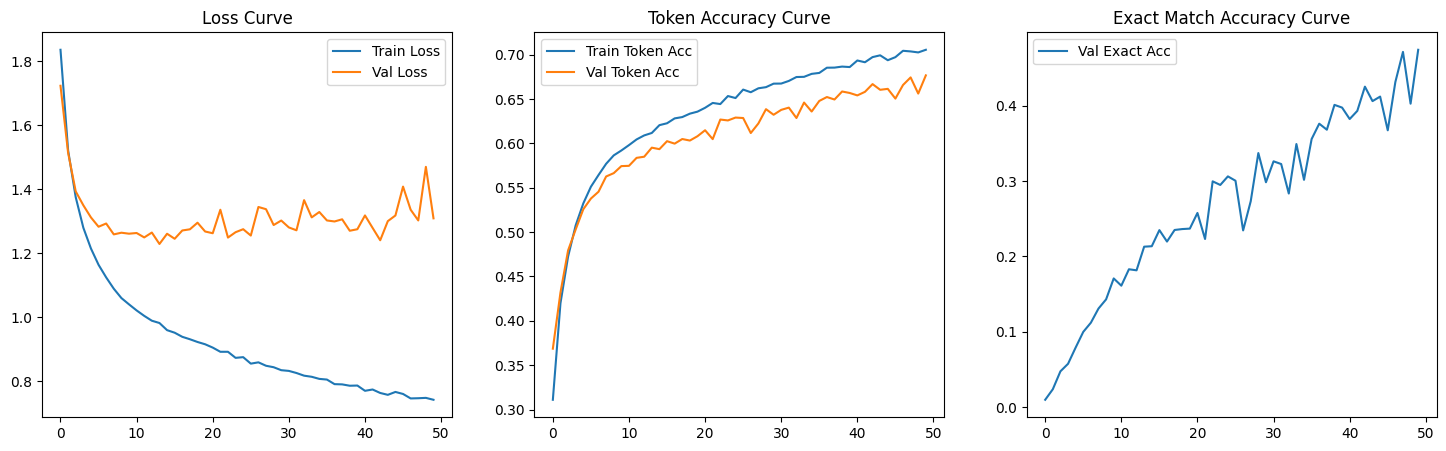

훈련 결과, 그래프, 모델 가중치, 메타정보를 'results_seq2seq_add_3num' 폴더에 저장했습니다.


In [8]:
# ----------------------------------------------------------
# 학습 완료 후 결과 저장 (Seq2Seq, Attention 없음)
# ----------------------------------------------------------

import os
import json
import pickle
import matplotlib.pyplot as plt

# 저장 디렉토리 생성
save_dir = "results_seq2seq_add_3num"
os.makedirs(save_dir, exist_ok=True)

# 1) 학습 로그 (loss, acc 기록) 저장
history = {
    "train_losses": [float(x) for x in train_losses],
    "val_losses": [float(x) for x in val_losses],
    "train_accs": [float(x) for x in train_accs],
    "val_accs": [float(x) for x in val_accs],
    "val_exact_accs": [float(x) for x in val_exact_accs],
}
with open(os.path.join(save_dir, "history.json"), "w") as f:
    json.dump(history, f, indent=2)

# 2) 학습 곡선 그래프 저장
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,3,2)
plt.plot(train_accs, label="Train Token Acc")
plt.plot(val_accs, label="Val Token Acc")
plt.legend(); plt.title("Token Accuracy Curve")

plt.subplot(1,3,3)
plt.plot(val_exact_accs, label="Val Exact Acc")
plt.legend(); plt.title("Exact Match Accuracy Curve")

plt.savefig(os.path.join(save_dir, "training_curves.png"), dpi=200, bbox_inches="tight")
plt.show()
plt.close()

# 3) 모델 가중치 저장
torch.save(model.state_dict(), os.path.join(save_dir, "results_seq2seq_add_3num.pt"))

# 4) 메타 정보 저장 (옵션)
meta = {
    "input_dim": INPUT_DIM,
    "output_dim": OUTPUT_DIM,
    "emb_dim": EMB_DIM,
    "hidden_dim": HIDDEN_DIM,
    "n_epochs": N_EPOCHS,
    "best_val_exact": max(val_exact_accs) if val_exact_accs else None
}
with open(os.path.join(save_dir, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)


#5) stoi / itos 저장
with open(os.path.join(save_dir, "stoi.pkl"), "wb") as f:
    pickle.dump(train_dataset.stoi, f)

with open(os.path.join(save_dir, "itos.pkl"), "wb") as f:
    pickle.dump(train_dataset.itos, f)
    


print(f"훈련 결과, 그래프, 모델 가중치, 메타정보를 '{save_dir}' 폴더에 저장했습니다.")


In [9]:
# ==============================
# 9.3.4 모델 예측과 샘플 확인 (3자리 덧셈 Seq2Seq)
# ==============================

# ------------------------------
# 예시 출력 (테스트 데이터에서 샘플 확인)
# ------------------------------
@torch.no_grad()
def show_examples_seq2seq(model, test_data, n=5):
    indices = random.sample(range(len(test_data)), n)
    print("\n=== 3자리 덧셈 예시 (Seq2Seq) ===")
    for idx in indices:
        _, _, src_str, tgt_str = test_data[idx]
        pred_raw = evaluate_seq2seq(
            model, src_str,
            stoi=train_dataset.stoi,
            itos=train_dataset.itos,
            device=device,
            max_len=len(tgt_str)
        )

        # 오차 계산 (공백 포함한 문자열 그대로 비교)
        pred_str = pred_raw
        true_str = tgt_str
        try:
            error = abs(int(true_str.strip()) - int(pred_str.strip()))
        except:
            error = "N/A"

        print(f"문제: {src_str:<8} | 정답: {true_str:<6} | 예측: {pred_str:<6} | 오차: {error}")


# ------------------------------
# 실행: 테스트 데이터 무작위 5개 확인
# ------------------------------
show_examples_seq2seq(model, test_dataset, n=5)


# ------------------------------
# 임의 입력 확인
# ------------------------------
custom_examples = [
    "396+32 ",
    "543+111",
    "100+390",
    "246+135",
    "88+1   "   # 실제 공백 포함 케이스
]

print("\n=== 임의 입력 예시 (Seq2Seq) ===")
for x in custom_examples:
    # 입력 그대로 사용 (공백 포함)
    src_proc = x  

    pred_raw = evaluate_seq2seq(
        model, src_proc,
        stoi=train_dataset.stoi,
        itos=train_dataset.itos,
        device=device,
        max_len=4   # 항상 출력 길이 4로 고정
    )

    # 정답 계산
    try:
        a, b = x.replace(" ", "").split("+")
        true = str(int(a) + int(b)).rjust(4)  # 항상 4자리, 공백 패딩
    except:
        true = "N/A"

    pred_str = pred_raw
    try:
        error = abs(int(true.strip()) - int(pred_str.strip()))
    except:
        error = "N/A"

    print(f"문제: {x:<8} | 정답: {true:<6} | 예측: {pred_str:<6} | 오차: {error}")



=== 3자리 덧셈 예시 (Seq2Seq) ===
문제: 491+175  | 정답: 666    | 예측: 666    | 오차: 0
문제: 62+761   | 정답: 823    | 예측: 823    | 오차: 0
문제: 98+394   | 정답: 492    | 예측: 490    | 오차: 2
문제: 515+805  | 정답: 1320   | 예측: 1321   | 오차: 1
문제: 643+8    | 정답: 651    | 예측: 650    | 오차: 1

=== 임의 입력 예시 (Seq2Seq) ===
문제: 396+32   | 정답:  428   | 예측: 427    | 오차: 1
문제: 543+111  | 정답:  654   | 예측: 654    | 오차: 0
문제: 100+390  | 정답:  490   | 예측: 400    | 오차: 90
문제: 246+135  | 정답:  381   | 예측: 381    | 오차: 0
문제: 88+1     | 정답:   89   | 예측: 88     | 오차: 1


In [10]:
import os
import torch
import torch.nn as nn
import pickle

# ===========================================
# 0. 저장된 폴더 지정
# ===========================================
save_dir = "results_seq2seq_add_3num"  # 학습 시 사용한 동일 폴더

# ===========================================
# 1. stoi / itos 불러오기
# ===========================================
with open(os.path.join(save_dir, "stoi.pkl"), "rb") as f:
    stoi = pickle.load(f)
with open(os.path.join(save_dir, "itos.pkl"), "rb") as f:
    itos = pickle.load(f)

# ===========================================
# 2. 모델 구조 정의 (학습 때와 동일)
# ===========================================
# Encoder 정의
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

    def forward(self, src):
        """
        src: [batch_size, src_len=7]  예: "123+456"
        """
        embedded = self.embedding(src)                   # [B, 7, E]
        _, (hidden, cell) = self.lstm(embedded)          # hidden/cell: [L, B, H]
        return hidden, cell

# Decoder 정의
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, hidden, cell):
        """
        input: [B]  (단일 토큰 인덱스, '_' 또는 숫자/공백 등)
        hidden, cell: [num_layers, B, H]
        """
        input = input.unsqueeze(1)                       # [B, 1]
        embedded = self.embedding(input)                 # [B, 1, E]
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))      # [B, vocab]
        return prediction, hidden, cell

# Seq2Seq (inference에서는 forward를 직접 쓰지 않아도 됨)
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

# ===========================================
# 3. 모델 불러오기
# ===========================================
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

# 하이퍼파라미터는 학습 때와 동일해야 함
INPUT_DIM = len(stoi)     # 입력 vocab 크기
OUTPUT_DIM = len(itos)    # 출력 vocab 크기 (대개 동일하지만 itos 기준 사용 권장)
EMB_DIM = 32              # 학습 시 사용한 값과 동일하게
HIDDEN_DIM = 192          # 학습 시 사용한 값과 동일하게
NUM_LAYERS = 1
DROPOUT = 0.0

enc = Encoder(INPUT_DIM, EMB_DIM, HIDDEN_DIM, num_layers=NUM_LAYERS, dropout=DROPOUT).to(device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HIDDEN_DIM, num_layers=NUM_LAYERS, dropout=DROPOUT).to(device)
loaded_model = Seq2Seq(enc, dec, device).to(device)

# 모델 가중치 불러오기
state_dict = torch.load(
    os.path.join(save_dir, "results_seq2seq_add_3num.pt"),
    map_location=device,
    weights_only=True   # 보안 강화 옵션
)
loaded_model.load_state_dict(state_dict)
loaded_model.eval()

# ===========================================
# 4. 예측 함수 (출력: '_' + 네 자리, SOS/EOS 없음)
# ===========================================
@torch.no_grad()
def evaluate_seq2seq(model, src_str, stoi, itos, device):
    # 입력 문자열을 인덱스로 변환
    src = torch.tensor([stoi[c] for c in src_str], device=device).unsqueeze(0)  # [1, 7]
    # 인코더
    hidden, cell = model.encoder(src)

    # 디코더: 우리는 시작 토큰으로 '_'를 직접 사용
    outputs = ["_"]
    input_tok = torch.tensor([stoi["_"]], device=device)  # 첫 입력은 '_' 고정

    # 뒤 4자리 생성
    for _ in range(4):
        logits, hidden, cell = model.decoder(input_tok, hidden, cell)
        top1 = logits.argmax(1)           # [1]
        outputs.append(itos[top1.item()]) # 토큰 → 문자
        input_tok = top1                  # 다음 step의 입력

    return "".join(outputs)  # 총 길이 5

# ===========================================
# 5. 테스트 입력
# ===========================================
test_input = "123+456"
prediction = evaluate_seq2seq(loaded_model, test_input, stoi, itos, device)

print(f"문제: {test_input}")
print(f"예측: '{prediction}'")  # 공백까지 확인을 위해 따옴표로 감쌈


문제: 123+456
예측: '_578 '
